## This code implements the neural network, simulating errors by flipping the sign of the weights of the activation layer, given some probability

-

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow
import matplotlib
from tensorflow import keras
from tensorflow.keras.datasets import cifar10,mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import sys
sys.path.insert(0, '..')
from binarization_utils import *
from model_architectures import get_model

from tensorflow.keras import activations

In [2]:
print(tf.__version__) #2.4.4
print(keras.__version__) #2.4.0

2.4.4
2.4.0


In [3]:
dataset='CIFAR-10'
Train=False
Evaluate=True
batch_size=100
epochs=200

In [4]:
use_generator=True
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [5]:
X_train=X_train.astype(np.float32)
X_test=X_test.astype(np.float32)
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)
X_train /= 255
X_test /= 255
X_train=2*X_train-1
X_test=2*X_test-1


print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


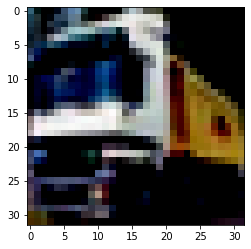

In [6]:
plt.imshow(X_train[1])

In [7]:
# the following cell block defines the activation layer that simulates the errors

# prob stores the probability of a sign flipping (1 -> -1 or -1 -> 1)
prob = 0
    
class Nonideal_sign(Layer):
    def __init__(self, levels=1,**kwargs):
        self.levels=levels
        super(Nonideal_sign, self).__init__(**kwargs)
    def build(self, input_shape):
        ars=np.arange(self.levels)+1.0
        ars=ars[::-1]
        means=ars/np.sum(ars)
        self.means=[K.variable(m) for m in means]
        self._trainable_weights = self.means
    def call(self, x, mask=None):
        resid = x
        out_bin=0
        for l in range(self.levels):
            out=binarize(resid)*(K.abs(self.means[l]))*((2*tf.cast(tf.random.uniform(self.means[l].shape) > prob, tf.float32)) - 1)
            out_bin=out_bin+out
            resid=resid-out
        return out_bin
    
        # the following lines were an idea to implement flips using tensor operations
        '''positive_mask = tf.cast(out_bin > 0, tf.float32)
        negative_mask = tf.cast(out_bin < 0, tf.float32)
        
        positive_flips = tf.random.uniform(out_bin.shape) < p[1]
        positives = tf.math.multiply(positive_mask, (tf.cast(tf.random.uniform(out_bin.shape) < p[1], tf.float32) - 1))
        negatives = tf.math.multiply(negative_mask, (tf.cast(tf.random.uniform(out_bin.shape) < p[0], tf.float32) - 1))
        return'''

    def get_output_shape_for(self,input_shape):
        return input_shape
    def compute_output_shape(self,input_shape):
        return input_shape
    def set_means(self,X):
        means=np.zeros((self.levels))
        means[0]=1
        resid=np.clip(X,-1,1)
        approx=0
        for l in range(self.levels):
            m=np.mean(np.absolute(resid))
            out=np.sign(resid)*m
            approx=approx+out
            resid=resid-out
            means[l]=m
            err=np.mean((approx-np.clip(X,-1,1))**2)

        means=means/np.sum(means)
        sess=K.get_session()
        sess.run(self.means.assign(means))

In [8]:
# construct the network

resid_levels=1
batch_norm_eps=1e-4
batch_norm_alpha=0.1#(this is same as momentum)

weights_path='models/'+dataset+'/'+str(resid_levels)+'_residuals.h5'

model=Sequential()
model.add(binary_conv(nfilters=64,ch_in=3,k=3,padding='valid',input_shape=[32,32,3]))
model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
model.add(Nonideal_sign(levels=resid_levels))
model.add(binary_conv(nfilters=64,ch_in=64,k=3,padding='valid'))
model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
model.add(Nonideal_sign(levels=resid_levels))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

model.add(binary_conv(nfilters=128,ch_in=64,k=3,padding='valid'))
model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
model.add(Nonideal_sign(levels=resid_levels))
model.add(binary_conv(nfilters=128,ch_in=128,k=3,padding='valid'))
model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
model.add(Nonideal_sign(levels=resid_levels))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

model.add(binary_conv(nfilters=256,ch_in=128,k=3,padding='valid'))
model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
model.add(Nonideal_sign(levels=resid_levels))
model.add(binary_conv(nfilters=256,ch_in=256,k=3,padding='valid'))
model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
model.add(Nonideal_sign(levels=resid_levels))
#model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

model.add(my_flat())

model.add(binary_dense(n_in=int(model.output.get_shape()[1]),n_out=512))
model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
model.add(Nonideal_sign(levels=resid_levels))
model.add(binary_dense(n_in=int(model.output.get_shape()[1]),n_out=512))
model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
model.add(Nonideal_sign(levels=resid_levels))
model.add(binary_dense(n_in=int(model.output.get_shape()[1]),n_out=10))
model.add(BatchNormalization(axis=-1, momentum=batch_norm_alpha, epsilon=batch_norm_eps))
model.add(Activation(activations.softmax))

2021-11-05 23:43:02.523696: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-05 23:43:02.525098: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model.load_weights(weights_path)
opt = keras.optimizers.Adam()

In [10]:
# probability of sign activation error
prob = 0.2

model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
#model.summary()
score=model.evaluate(X_test,Y_test,verbose=0)
print("with %d residuals, test loss was %0.4f, test accuracy was %0.4f"%(resid_levels,score[0],score[1]))

2021-11-05 23:43:06.019859: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


with 1 residuals, test loss was 4.4420, test accuracy was 0.2270


In [11]:
# test the neural network with varying error probabilities
probs = np.logspace(-7, -1)
errors = []

for p in probs:
    prob = p
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    #model.summary()
    score=model.evaluate(X_test,Y_test,verbose=0)
    print("with %d residuals, test loss was %0.4f, test accuracy was %0.4f"%(resid_levels,score[0],score[1]))
    errors = errors + [score[1]]
    

with 1 residuals, test loss was 0.6251, test accuracy was 0.7870
with 1 residuals, test loss was 0.6251, test accuracy was 0.7870
with 1 residuals, test loss was 0.6251, test accuracy was 0.7870
with 1 residuals, test loss was 0.6251, test accuracy was 0.7870
with 1 residuals, test loss was 0.6251, test accuracy was 0.7870
with 1 residuals, test loss was 0.6251, test accuracy was 0.7870
with 1 residuals, test loss was 0.6251, test accuracy was 0.7870
with 1 residuals, test loss was 0.6251, test accuracy was 0.7870
with 1 residuals, test loss was 0.6251, test accuracy was 0.7870
with 1 residuals, test loss was 0.6251, test accuracy was 0.7870
with 1 residuals, test loss was 0.6251, test accuracy was 0.7870
with 1 residuals, test loss was 0.6251, test accuracy was 0.7870
with 1 residuals, test loss was 0.6251, test accuracy was 0.7870
with 1 residuals, test loss was 0.6251, test accuracy was 0.7870
with 1 residuals, test loss was 0.6251, test accuracy was 0.7870
with 1 residuals, test lo

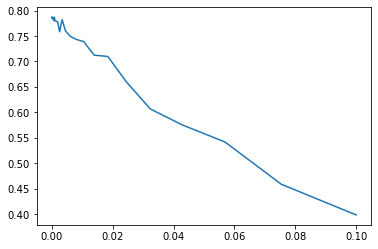

In [13]:
# plot the results
plt.plot(probs, errors)